# DengAI: Predicting Disease Spread

***

## Hypothesis
- Because dengue fever is a tropical disease, we would expect it to be more popular in place with high temperature, high precipitation and thus high humidity.
- The disease is transmitted by mosquitoes, whose peak season is summer, so we will expect summer to have more dengue cases than the rest of the year.
- Iquitos is a Peruvian port city and gateway to the jungle lodges and tribal villages of the northern Amazon. Surrounded by green spaces and water sources, it is an ideal environment for mosquitoes. San juan, in the other hand, is a city on an island (more isolated) and has a much lower population density than Iquitos. All these informations suggest that we will need 2 separate models, one for each city.

***

## Data reading

In [1]:
# -*- coding: utf-8 -*-
import re
import time
import datetime 
import operator
import numpy as np
import pandas as pd 
import collections
import unicodedata
import seaborn as sns
import collections
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt


from collections import Counter
from datetime import datetime, date, timedelta
from IPython.display import Image


%matplotlib inline

pylab.rcParams['figure.figsize'] = 13,10

plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']



In [13]:
feature = pd.read_csv('data/dengue_features_train.csv', infer_datetime_format=True)
label = pd.read_csv('data/dengue_labels_train.csv')

In [14]:
feature.shape

(1456, 24)

The dataset contains information on 1456 weeks for the 2 cities across 24 features.

In [15]:
feature.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [16]:
label.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Let's fusion the 2 dataframes:

In [17]:
df = pd.merge(feature, label, how='outer', on=label.columns.tolist()[:-1])

In [18]:
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Check duplicate rows:

In [19]:
np.sum(df.duplicated())

0

Check NA:

In [20]:
np.sum(df.isnull(),axis=0)

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

We drop all rows having less than 20 non-NA features

In [21]:
df = df.dropna(axis=0, thresh=20)

In [22]:
df.shape

(1446, 25)

In [23]:
np.sum(df.isnull(),axis=0)

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  189
ndvi_nw                                   47
ndvi_se                                   17
ndvi_sw                                   17
precipitation_amt_mm                       3
reanalysis_air_temp_k                      0
reanalysis_avg_temp_k                      0
reanalysis_dew_point_temp_k                0
reanalysis_max_air_temp_k                  0
reanalysis_min_air_temp_k                  0
reanalysis_precip_amt_kg_per_m2            0
reanalysis_relative_humidity_percent       0
reanalysis_sat_precip_amt_mm               3
reanalysis_specific_humidity_g_per_kg      0
reanalysis_tdtr_k                          0
station_avg_temp_c                        33
station_diur_temp_rng_c                   33
station_max_temp_c                        10
station_mi

Check the sanity of the "city" column

In [24]:
df.city.value_counts()

sj    930
iq    516
Name: city, dtype: int64

***

# EDA

In [25]:
df_sj = df[df.city == 'sj'].copy()
df_iq = df[df.city == 'iq'].copy()

In [26]:
df.columns.tolist()

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

/home/alvin/miniconda3/envs/DengAI/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


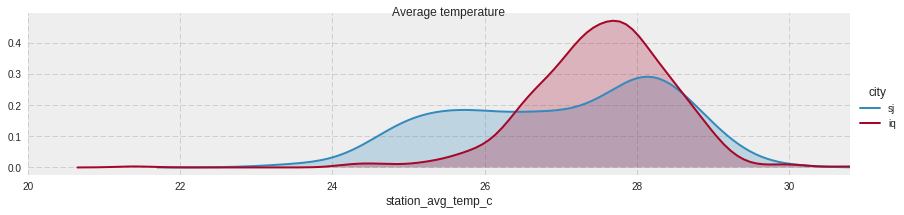

In [27]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.kdeplot,'station_avg_temp_c',shade=True)
max_x = df.station_avg_temp_c.max()
fig.set(xlim=(20,max_x))
fig.add_legend()
fig.fig.suptitle("Average temperature")

/home/alvin/miniconda3/envs/DengAI/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


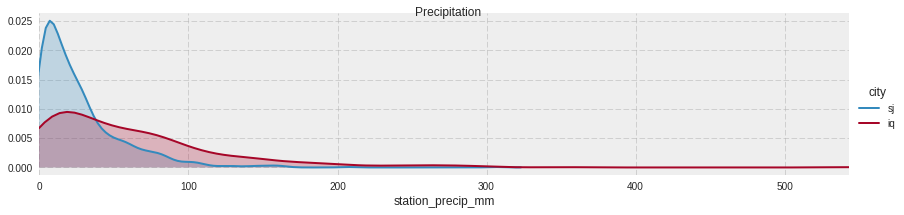

In [28]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.kdeplot,'station_precip_mm',shade=True)
max_x = df.station_precip_mm.max()
min_x = df.station_precip_mm.min()
fig.set(xlim=(0,max_x))
fig.add_legend()
fig.fig.suptitle("Precipitation")

Concerning the climate factors, we can say that Iquitos is generally a littlbe bit hotter than San Juan, and the precipitation is much higher. 

If what our hypothesis is true, the number of dengue cases in Iquitos must be higher than that of San juan.

/home/alvin/miniconda3/envs/DengAI/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


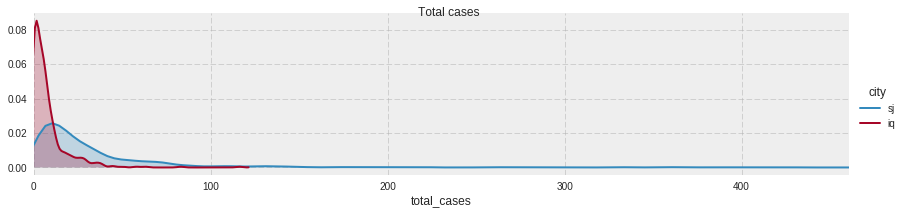

In [29]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.kdeplot,'total_cases',shade=True)
max_x = df.total_cases.max()
min_x = df.total_cases.min()
fig.set(xlim=(min_x,max_x))
fig.add_legend()
fig.fig.suptitle("Total cases")

In [30]:
df.groupby('city').mean().total_cases

city
iq     7.596899
sj    34.122581
Name: total_cases, dtype: float64

Surprisingly, San Juan has a lot more dengue cases than Iquitos 

Now let's check the evolution of dengue disease through time

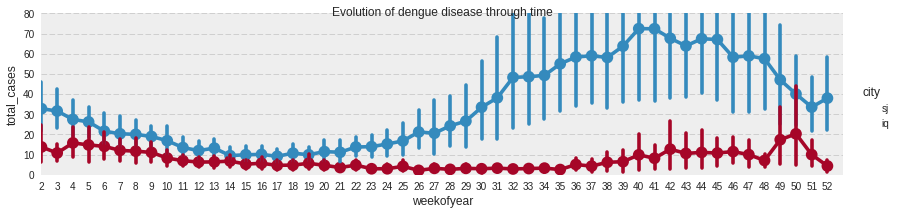

In [31]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.pointplot,'weekofyear','total_cases')
max_x = df.weekofyear.max()
min_x = df.weekofyear.min()
fig.set(xlim=(min_x,max_x))
fig.set(ylim=(0, 80))
fig.add_legend()
fig.fig.suptitle("Evolution of dengue disease through time")

In San Juan, one clear trend is that the dengue virus becomes a lot more active at the other half of the year, starting from July (week 28).

In Iquitos, the disease develop much slower, with its peak at the very end of the year (week 50).

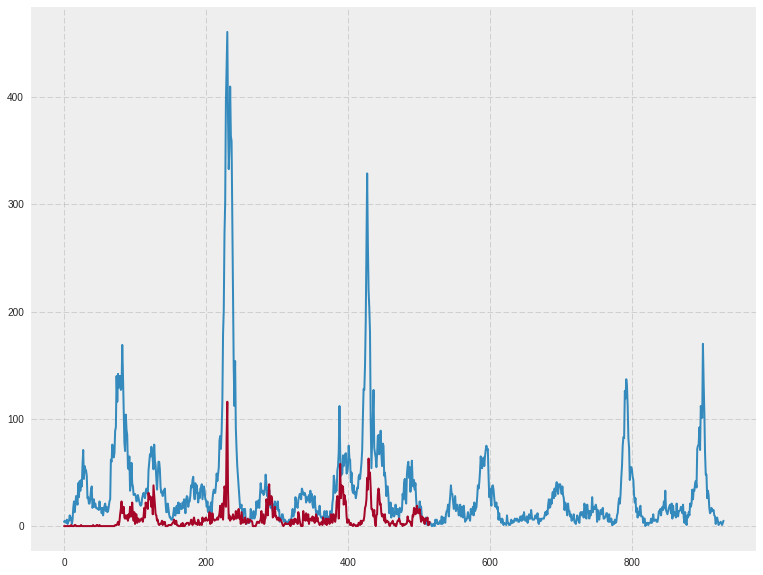

In [32]:
plt.plot(range(len(df_sj)), df_sj.total_cases.values)
plt.plot(range(len(df_iq)), df_iq.total_cases.values)

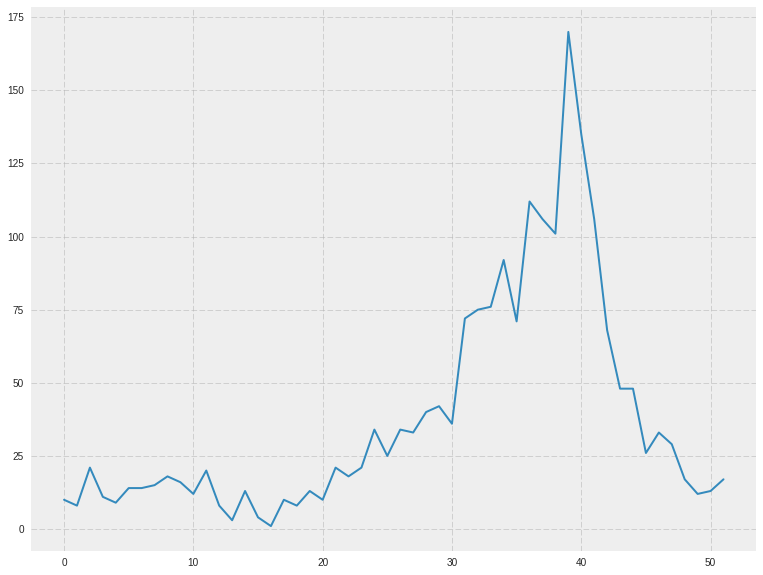

In [33]:
plt.plot(range(len(df_sj[df_sj.year==2007])), df_sj[df_sj.year==2007].total_cases.values)

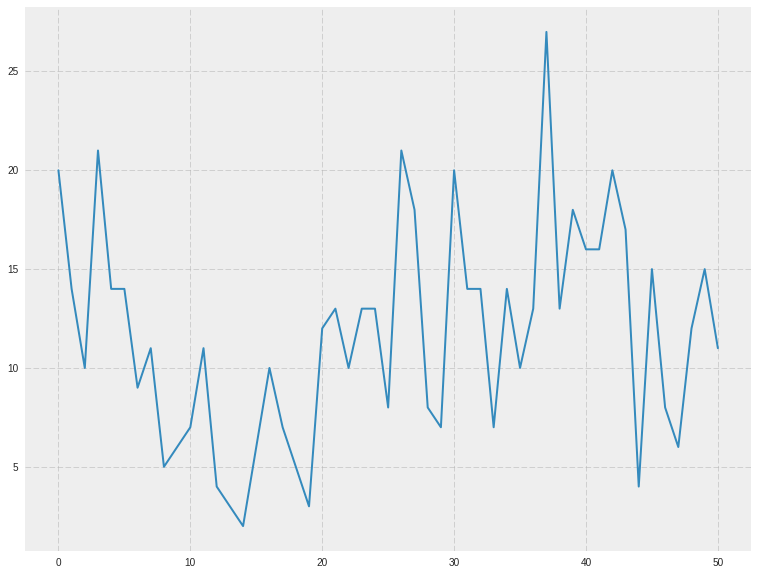

In [34]:
plt.plot(range(len(df_sj[df_sj.year==2004])), df_sj[df_sj.year==2004].total_cases.values)

# Baseline model

In [2]:
from sklearn import cross_validation, metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

/home/alvin/miniconda3/envs/DengAI/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
def modelfit(alg, dtrain, predictors, target, n_fold=10):
    alg.fit(dtrain[predictors], dtrain[target])
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_prediction = np.round(dtrain_predictions)
    
    cv_mae_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=n_fold, scoring='neg_mean_absolute_error') 
    cv_mae_score = np.abs(cv_mae_score)
  
    
    #Print model report:
    print ("\nModel Report: {0}-fold cross-validation".format(n_fold))
    #print "RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions))

    print ("Mean absolute error on training set: %.4g" % metrics.mean_absolute_error(dtrain[target].values, dtrain_predictions))
    print ("Mean - %.4g | Median - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_mae_score),
                                                                                  np.median(cv_mae_score),
                                                                                  np.std(cv_mae_score),
                                                                                  np.min(cv_mae_score), 
                                                                                  np.max(cv_mae_score)))
    

def baseline_test(test_df, predictors, target, plotting=False, num_feature=10): 
# InteractiveShell.ast_node_interactivity = "all"ictors, target, plotting=False, num_feature=10): 
    
#     base_result = test_df[target][:]
#     base_result[:] = base_result.mean(axis=0)
#     print "NAIVE MODEL: all predictions = mean value" 
#     print "Mean absolute error : %.4g" % np.sqrt(metrics.mean_squared_error(test_df[target].values, base_result))
#     print "----------------------------------------"
    
#     lm = LinearRegression(normalize=False)
#     print "LINEAR REGRESSION" 
#     modelfit(lm, test_df, predictors, target)
#     coef1 = pd.Series(lm.coef_, predictors).sort_values()
#     if plotting: 
#         coef1.plot(kind='barh', title='Model Coefficcients')
#         plt.show()
#     print "----------------------------------------"

    lasso = Lasso(alpha = .01, normalize=True)
    print ("LASSO REGRESSION")
    modelfit(lasso, test_df, predictors, target)
    coef1 = pd.Series(lasso.coef_, predictors).sort_values()
    if plotting: 
        coef1.plot(kind='barh', title='Model Coefficcients')
        plt.show()
    print ("----------------------------------------")

    print ("RANDOM FOREST")
    rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
    modelfit(rf, test_df, predictors, target)
    rf.fit(test_df[predictors], test_df[target])
    rf.feature_importances_
#     sorted_features =  sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), predictors), 
#                  reverse=True)
    sorted_features = pd.Series(rf.feature_importances_, predictors).sort_values(ascending=False)

#     for x,y in sorted_features: 
#         print y,x 

    if plotting: 
        print ("FEATURES SORTED BY THEIR SCORE:\n")
        sorted_features[::-1].plot(kind='barh')
        
    #print "----------------------------------------"

    return sorted_features[:num_feature].index.tolist() # return top 10 features

We will encode the "city" feature

In [37]:
df = df.join(pd.get_dummies(df.city))

In [38]:
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,iq,sj
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,0,1
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,0,1
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,0,1
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,0,1
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,0,1


We create the list of predictors

In [39]:
np.sum(df.isnull(), axis=0)

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  189
ndvi_nw                                   47
ndvi_se                                   17
ndvi_sw                                   17
precipitation_amt_mm                       3
reanalysis_air_temp_k                      0
reanalysis_avg_temp_k                      0
reanalysis_dew_point_temp_k                0
reanalysis_max_air_temp_k                  0
reanalysis_min_air_temp_k                  0
reanalysis_precip_amt_kg_per_m2            0
reanalysis_relative_humidity_percent       0
reanalysis_sat_precip_amt_mm               3
reanalysis_specific_humidity_g_per_kg      0
reanalysis_tdtr_k                          0
station_avg_temp_c                        33
station_diur_temp_rng_c                   33
station_max_temp_c                        10
station_mi

In [40]:
ignore_feature_list = ['city', 'ndvi_ne', 'week_start_date', 'total_cases']

In [41]:
predictors = [feature for feature in df.columns.tolist() if feature not in ignore_feature_list]
target = 'total_cases'

For the remaining feature with nan values, for now we will just fill the nan values with their mean

In [42]:
df_mean = df.fillna(df.mean())

Ok let's run the baseline models

LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 20.02
Mean - 21.25 | Median - 19.39 | Std - 10.72 | Min - 7.408 | Max - 46.73


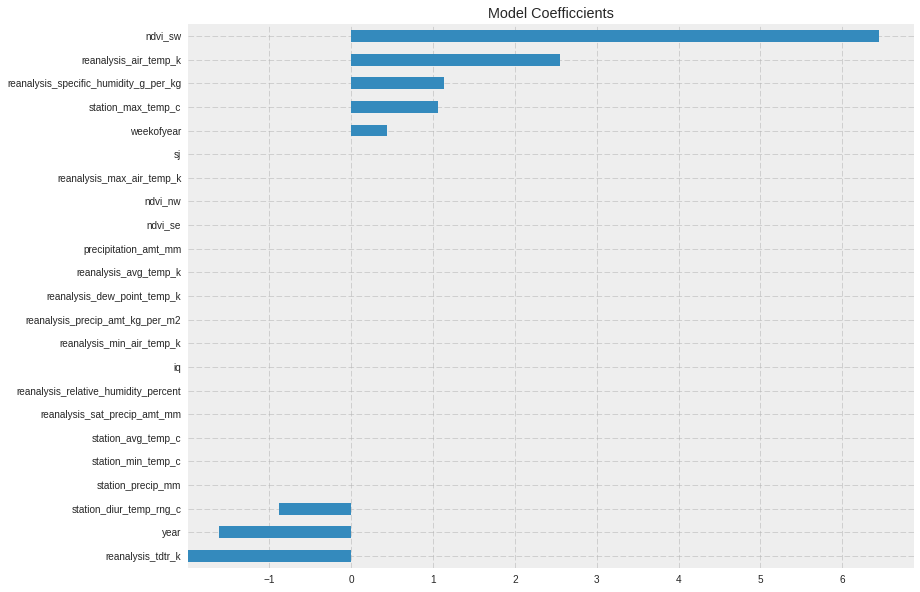

----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 4.476
Mean - 20.05 | Median - 17.83 | Std - 12.57 | Min - 6.627 | Max - 47.61
FEATURES SORTED BY THEIR SCORE:



['year',
 'weekofyear',
 'ndvi_nw',
 'ndvi_sw',
 'reanalysis_air_temp_k',
 'ndvi_se',
 'station_max_temp_c',
 'reanalysis_precip_amt_kg_per_m2',
 'station_precip_mm',
 'reanalysis_dew_point_temp_k']

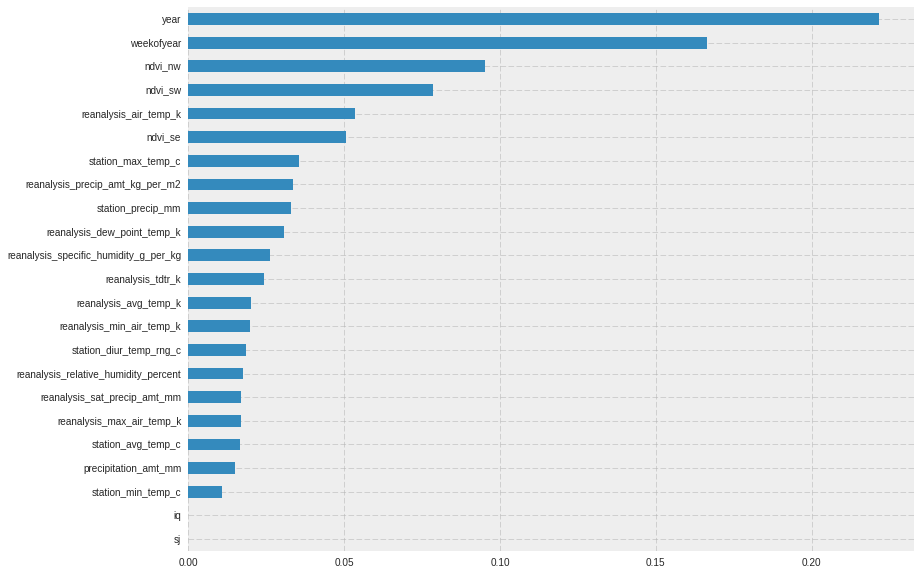

In [43]:
baseline_test(df_mean, predictors, target, plotting=True)

***

## First submission

In [44]:
test = pd.read_csv('data/dengue_features_test.csv')

In [45]:
#test = test.fillna(df.mean())

In [46]:
test = test.join(pd.get_dummies(test.city))

In [13]:
def make_prediction(alg, train_df, test_df, predictors, target):

    alg.fit(train_df[predictors], train_df[target])
    predictions = alg.predict(test_df[predictors])
    
    result_df = test_df[['city', 'year', 'weekofyear']].copy()
    result_df['total_cases'] = predictions
    result_df.total_cases = result_df.total_cases.round()
    result_df.total_cases = result_df.total_cases.astype(int)
    
    return result_df

In [48]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
result = make_prediction(rf, df, test, predictors, target)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
result.to_csv('submission.csv', index=False)

This model gave a leaderboard error of 26,3173.

***

# Separated models

We will build 1 model for each city

In [ ]:
df_mean.city.value_counts()

In [ ]:
baseline_test(df_sj, predictors[:-2], target) # omit the 2 dummy predictors about city
print '***********************************************************'
baseline_test(df_iq, predictors[:-2], target)

The model works well with Iquitos but not San Juan

In [ ]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

result_sj = make_prediction(rf, df_sj, test_sj, predictors[:-2], target)
result_iq =  make_prediction(rf, df_iq, test_iq, predictors[:-2], target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

This model gave an error rate of 26.1466 on the leaderboard, a slight improvement.

Wee can see that the model of San Juan doesn't work very well, so for now we will concentrate on it.

***

## Gaussian Process

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

from sklearn.model_selection import KFold

import GPy

There are different implementations of Gaussian Process in Python, 2 of which are **sklearn** and **GPy**. The sklearn's implementation obviously has an advantage because it shares the same api with other function that we use, but **GPy** seems to be prefered by researchers and have a lot more options. 

We will test them on our dataset with cross-validation.

In [ ]:
kf = KFold(n_splits=10)

sk_error_list = []
gpy_error_list = []

sk_time = []
gpy_time = []

for train_index, test_index in kf.split(df_sj):
    
    X_train, X_test = df_sj[predictors[:-2]].iloc[train_index].values, df_sj[predictors[:-2]].iloc[test_index].values
    y_train, y_test = df_sj[target].iloc[train_index].values.reshape(-1,1), df_sj[target].iloc[test_index].values.reshape(-1,1)
    
    # gaussian process of sklearn
    t0 = time.clock()
    
    rbf_kernel = RBF()
    gp = GaussianProcessRegressor(kernel=rbf_kernel, n_restarts_optimizer=10, normalize_y=True)
    gp.fit(X_train, y_train)
    gp_prediction = np.round(gp.predict(X_test))
    sk_error = metrics.mean_absolute_error(gp_prediction, y_test)
    sk_error_list.append(sk_error)
    
    sk_time.append(time.clock() - t0)
    
    # gaussian process of GPy
    t0 = time.clock()
    
    kernel = GPy.kern.RBF(input_dim=len(predictors[:-2]), variance=1., lengthscale=1.)
    m_sj = GPy.models.GPRegression(X_train, y_train, kernel)
    m_sj.optimize(messages=False)
    mean_sj, sigma_sj = m_sj.predict(X_test)
    mean_sj = np.round(mean_sj)
    gpy_error = metrics.mean_absolute_error(mean_sj, y_test)
    gpy_error_list.append(gpy_error)
    
    gpy_time.append(time.clock() - t0)

    
print "Sklearn GP: mean {0:.2f} - std {1:.2f} - processing time {2} s".format(np.mean(sk_error_list), np.std(sk_error_list), np.mean(sk_time))
print "GPy GP: mean {0:.2f} - std {1:.2f} - processing time {2} s".format(np.mean(gpy_error_list), np.std(gpy_error_list), np.mean(gpy_time))

We see that the 2 implementations give quite the same results, but GPy takes a lot more time. 

From now on, we will work with the sklearn GP.

Let's try a simple additive kernel to capture the short-term and long-term trend in our data.

In [ ]:
additive_rbf_kernel = RBF(1) + RBF(10)
gp = GaussianProcessRegressor(kernel=additive_rbf_kernel, n_restarts_optimizer=10, normalize_y=True)

modelfit(gp, df_sj, predictors[:-2], target)

In [ ]:
additive_rbf_kernel = RBF(1) 
gp = GaussianProcessRegressor(kernel=additive_rbf_kernel, n_restarts_optimizer=10, normalize_y=True)

modelfit(gp, df_sj, predictors[:-2], target)

In [ ]:
additive_rbf_kernel = RBF(1) + RBF(10) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=additive_rbf_kernel, n_restarts_optimizer=10, normalize_y=True)

modelfit(gp, df_sj, predictors[:-2], target)

In [ ]:
additive_rbf_kernel = RBF(1) + RationalQuadratic() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=additive_rbf_kernel, n_restarts_optimizer=10, normalize_y=True)

modelfit(gp, df_sj, predictors[:-2], target)

The simple 2 rbf model seems to be the best. Let's make a submission:

In [ ]:
additive_rbf_kernel = RBF(1) + RBF(10)
gp = GaussianProcessRegressor(kernel=additive_rbf_kernel, n_restarts_optimizer=10, normalize_y=True)


result_sj = make_prediction(gp, df_sj, test_sj, predictors[:-2], target)
result_iq =  make_prediction(gp, df_iq, test_iq, predictors[:-2], target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

The result is a little better than the original model with 1 RBF, but still inferior than the Random Forest approach.

# Model diagnostic

Plotting the learning curve is usually a good idea to see what the problem is.

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_absolute_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
%%time

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

X = df_sj[predictors[:-2]]
y = df_sj[target]

# title = "Learning Curves (Gaussian Process)"
title = "Learning Curves (Random Forest)"

# Cross validation with 20 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
#cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

#rbf_kernel = RBF()
#gp = GaussianProcessRegressor(kernel=rbf_kernel, n_restarts_optimizer=10, normalize_y=True)
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
plot_learning_curve(rf, title, X, y, cv=10, n_jobs=-1)

plt.show()

## Improvement

First, we will examine the data imputation step. Before, we use mean imputation, however in case of time serie data, a forward fill imputation might be more appropriate. 

We will create a processing function to make sure that we don't forget any steps. We will complete this function as we go.

In [3]:
def processing_function(df):
    
    df.fillna(method='ffill', inplace=True)
    
    df_sj = df.loc[df.city == 'sj']
    df_iq = df.loc[df.city == 'iq']
    
    return df_sj, df_iq
    

In [4]:
feature = pd.read_csv('data/dengue_features_train_m.csv', infer_datetime_format=True)
label = pd.read_csv('data/dengue_labels_train.csv')
test = pd.read_csv('data/dengue_features_test_m.csv')
df = pd.merge(feature, label, how='outer', on=label.columns.tolist()[:-1])
df = df.dropna(axis=0, thresh=20)
df_sj = df[df.city == 'sj'].copy()
df_iq = df[df.city == 'iq'].copy()
df

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,5,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,5,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,5,6
5,sj,1990,23,1990-06-04,NaN,0.174850,0.254314,0.181743,9.58,299.630000,...,9.58,17.212857,2.100000,28.114286,6.942857,34.4,23.9,39.1,6,2
6,sj,1990,24,1990-06-11,0.112900,0.092800,0.205071,0.210271,3.48,299.207143,...,3.48,17.234286,2.042857,27.414286,6.771429,32.2,23.3,29.7,6,4
7,sj,1990,25,1990-06-18,0.072500,0.072500,0.151471,0.133029,151.12,299.591429,...,151.12,17.977143,1.571429,28.371429,7.685714,33.9,22.8,21.1,6,5
8,sj,1990,26,1990-06-25,0.102450,0.146175,0.125571,0.123600,19.32,299.578571,...,19.32,17.790000,1.885714,28.328571,7.385714,33.9,22.8,21.1,6,10
9,sj,1990,27,1990-07-02,NaN,0.121550,0.160683,0.202567,14.41,300.154286,...,14.41,18.071429,2.014286,28.328571,6.514286,33.9,24.4,1.1,7,6


In [5]:
sj, iq = processing_function(df)
test_sj, test_iq = processing_function(test)

In [6]:
print(df_sj)
print(df_iq)

    city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0     sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1     sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2     sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3     sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4     sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   
5     sj  1990          23      1990-06-04       NaN  0.174850  0.254314   
6     sj  1990          24      1990-06-11  0.112900  0.092800  0.205071   
7     sj  1990          25      1990-06-18  0.072500  0.072500  0.151471   
8     sj  1990          26      1990-06-25  0.102450  0.146175  0.125571   
9     sj  1990          27      1990-07-02       NaN  0.121550  0.160683   
10    sj  1990          28      1990-07-09  0.192875  0.082350  0.191943   
11    sj  1990          29      1990-07-16  0.291600  0.211800  0.301200   
12    sj  19

In [10]:
predictors

['year',
 'weekofyear',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'month']

In [9]:
ignore_feature_list = ['city', 'ndvi_ne', 'week_start_date', 'total_cases']
predictors = [feature for feature in df.columns.tolist() if feature not in ignore_feature_list]
target = 'total_cases'
# top10_feature_sj = baseline_test(sj, predictors, target) # omit the 2 dummy predictors about city

# top10_feature_iq = baseline_test(iq, predictors, target)

In [110]:
top10_feature_sj

['year',
 'ndvi_se',
 'weekofyear',
 'ndvi_sw',
 'reanalysis_dew_point_temp_k',
 'month',
 'station_max_temp_c',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_max_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2']

In [111]:
top10_feature_iq

['year',
 'weekofyear',
 'station_precip_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'station_avg_temp_c',
 'reanalysis_precip_amt_kg_per_m2',
 'ndvi_se',
 'station_min_temp_c',
 'station_max_temp_c',
 'station_diur_temp_rng_c']

In [113]:
top5_feature_sj = baseline_test(sj, predictors, target, num_feature=5) 

top5_feature_iq = baseline_test(iq, predictors, target, num_feature=5)

LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 27.11
Mean - 30.11 | Median - 23.88 | Std - 13.69 | Min - 17.87 | Max - 64.02
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 5.011
Mean - 29.8 | Median - 25.66 | Std - 16.54 | Min - 9.062 | Max - 64.81
LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 6.336
Mean - 7.131 | Median - 7.12 | Std - 1.702 | Min - 4.794 | Max - 9.834
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 1.931
Mean - 7.772 | Median - 7.927 | Std - 0.9935 | Min - 5.346 | Max - 9.026


In [ ]:
_ = baseline_test(sj, top10_feature_sj, target) 
_ = baseline_test(iq, top10_feature_iq, target)

In [ ]:
_ = baseline_test(sj, top5_feature_sj, target) 

_ = baseline_test(iq, top5_feature_iq, target)

In [114]:
top5_feature_iq

['year',
 'weekofyear',
 'station_precip_mm',
 'station_avg_temp_c',
 'reanalysis_specific_humidity_g_per_kg']

Ok it seems that with the best model is the one with 5 features. Let's make a submssion.

In [ ]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

result_sj = make_prediction(rf, sj, test_sj, top5_feature_sj, target)
result_iq =  make_prediction(rf, iq, test_iq, top5_feature_iq, target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

27.545, Not good at all, we will try with 10 features.

In [ ]:
lasso = Lasso(alpha = .01, normalize=False)
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

result_sj = make_prediction(rf, sj, test_sj, top10_feature_sj, target)
result_iq =  make_prediction(lasso, iq, test_iq, top10_feature_iq, target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

In [17]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.hstack((ret[:n-1],ret[n - 1:] / n))



def general_rolling_cross_validation(df_sj, df_iq, alg_sj, alg_iq, predictors_sj, predictors_iq, target='total_cases', 
                                     time_step=4, rolling_step=3):
    
    fold_size_sj = df_sj.shape[0]/(time_step+1)
    fold_size_iq = df_iq.shape[0]/(time_step+1)
    
    
    error_list = []
    print(time_step)
    
    for i in range(1, time_step-1):
        
        train_sj = df_sj.iloc[: (i+1)*int(fold_size_sj)]
        test_sj = df_sj.iloc[(i+1)*int(fold_size_sj): ]#(i+2)*fold_size_sj]
        
        train_iq = df_iq.iloc[: (i+1)*int(fold_size_iq)]
        test_iq = df_iq.iloc[(i+1)*int(fold_size_iq): ]#(i+2)*fold_size_iq]
            
        new_train_sj, new_test_sj = add_groupby_feature(train_sj, test_sj)
        new_train_iq, new_test_iq = add_groupby_feature(train_iq, test_iq)
#         print(new_train_sj)
#         print(new_train_iq)

        pred_sj = predictors_sj + ['mean_total_cases_by_month']
        pred_iq = predictors_iq + ['mean_total_cases_by_month']
            
                    
        alg_sj.fit(new_train_sj[pred_sj], new_train_sj[target])
        predictions_sj = alg_sj.predict(new_test_sj[pred_sj])
        
        alg_iq.fit(new_train_iq[pred_iq], new_train_iq[target])
        predictions_iq = alg_iq.predict(new_test_iq[pred_iq])
        
        predictions = np.hstack((predictions_sj, predictions_iq))
        
        if rolling_step > 0:
            predictions = moving_average(predictions, n=rolling_step)

        true_values = np.hstack((test_sj[target], test_iq[target]))
        
        error = metrics.mean_absolute_error(np.round(predictions), true_values)
        
        error_list.append(error)
        
    
    print ("Rolling cross-validation: ") 
    print ("Mean {0:.2f} - Median {1:.2f} - Std {2:.2f}".format(np.mean(error_list), np.median(error_list), np.std(error_list)))  
    return error_list
        

def rolling_cross_validation(df, alg, predictors, target='total_cases', time_step=4, rolling_step=3):
    
    fold_size = df.shape[0]/(time_step+1)
    
    error_list = []
    
    for i in range(1,time_step-1):
        
        train = df.iloc[: (i+1)*fold_size]
        test = df.iloc[(i+1)*fold_size: (i+2)*fold_size]
           
        new_train, new_test = add_groupby_feature(train, test)
        pred = predictors + ['mean_total_cases_by_month']

        alg.fit(new_train[pred], new_train[target])
        predictions = alg.predict(new_test[pred])        
     
        if rolling_step > 0:
            predictions = moving_average(predictions, n=rolling_step)
        
        error = metrics.mean_absolute_error(np.round(predictions), test[target])
        
        error_list.append(error)
        
    
    #print "Rolling cross-validation: ", 
    #print "Mean {0:.2f} - Median {1:.2f} - Std {2:.2f}".format(np.mean(error_list), np.median(error_list), np.std(error_list))
    
    return np.mean(error_list)
        

In [21]:
def add_groupby_feature(train_df, test_df): 
     
    five_year_ago = train_df.year.max() - 5
    df_month = train_df[train_df.year >= five_year_ago].groupby('month', as_index = False)

    feature_name = 'mean_total_cases_by_month'
    
    total_cases_by_month = df_month['total_cases'].mean()
    total_cases_by_month.rename(columns={'total_cases': feature_name}, inplace=True)

    train_merged_df = pd.merge(train_df, total_cases_by_month, how = 'left', on='month')
    test_merged_df = pd.merge(test_df, total_cases_by_month, how = 'left', on='month')
    print(train_merged_df['mean_total_cases_by_month'])
    
    return train_merged_df, test_merged_df

In [55]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

best_score = np.inf


def hyperopt_train_test_sj(params):
    
    rf = RandomForestRegressor(**params)
    
    return rolling_cross_validation(sj, rf, predictors[:-2])
    
    
def score_sj(params):
    
    global best_score    
        
    params = {feature: int(value) for feature, val in params.items() if type(val)=='float'}
    
    score = hyperopt_train_test_sj(params)
    
    if score < best_score: 
        print ("Searching...") 
        print ("New best score: {0}".format(score))
        best_score = score

    return {'loss': score, 'status': STATUS_OK}
    
def optimize_sj(trials):
        
    space = {
             'max_depth': hp.quniform('max_depth', 0, 30, 1),
             'max_features': hp.quniform('max_features', 0, len(predictors[:-2]), 1),
             'n_estimators': hp.qnormal('n_estimators', 500, 200, 1),
             'min_samples_split': hp.quniform('min_samples_split', 1, 100, 1),
             'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=500)

    print ("Done.")
    print ("Best parameter setting:", best)

In [56]:
trials_sj = Trials()
optimize_sj(trials_sj)

NameError: name 'score' is not defined

In [71]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

best_score = np.inf

def hyperopt_train_test_iq(params):
    
    rf = RandomForestRegressor(**params)
    
    return rolling_cross_validation(iq, rf, predictors[:-2])
    
    
def score_iq(params):
    
    global best_score    
    
    params = {feature: int(value) for feature, val in params.items() if type(val)=='float'}

    
    score = hyperopt_train_test_iq(params)
    
    if score < best_score: 
        print ("Searching...", )
        print ("New best score: {0}".format(score))
        best_score = score

    return {'loss': score, 'status': STATUS_OK}
    
def optimize_iq(trials):
        
    space = {
             'max_depth': hp.quniform('max_depth', 0, 30, 1),
             'max_features': hp.quniform('max_features', 0, len(predictors[:-2]), 1),
             'n_estimators': hp.qnormal('n_estimators', 500, 200, 1),
             'min_samples_split': hp.quniform('min_samples_split', 1, 100, 1),
             'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
             }

    best = fmin(score_iq, space, algo=tpe.suggest, trials=trials, max_evals=500)

    print ("Done.")
    print ( "Best parameter setting:", best)

In [ ]:
trials_iq = Trials()
optimize_iq(trials_iq)

These are the optimized parameters for the 2 models:

In [11]:
rf_sj = RandomForestRegressor(max_features=10, 
                              min_samples_split=88, 
                              n_estimators=674,
                              max_depth=18,
                              min_samples_leaf=3)

rf_iq = RandomForestRegressor(max_features=10, 
                              min_samples_split=19, 
                              n_estimators=200,
                              max_depth=16,
                              min_samples_leaf=5)

In [25]:
ignore_feature_list = ['city', 'ndvi_ne', 'week_start_date', 'total_cases']
predictors = [feature for feature in df.columns.tolist() if feature not in ignore_feature_list]
predictors

['year',
 'weekofyear',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'month']

In [22]:
    _ = general_rolling_cross_validation(sj, iq, rf_sj, rf_iq, predictors, predictors)

4
0       13.300000
1       12.625000
2       12.625000
3       12.625000
4       12.625000
5       16.375000
6       16.375000
7       16.375000
8       16.375000
9       24.500000
10      24.500000
11      24.500000
12      24.500000
13      24.500000
14      38.050000
15      38.050000
16      38.050000
17      38.050000
18      74.500000
19      74.500000
20      74.500000
21      74.500000
22     116.956522
23     116.956522
24     116.956522
25     116.956522
26     116.956522
27     102.900000
28     102.900000
29     102.900000
          ...    
342     63.950000
343     63.950000
344     63.950000
345     45.000000
346     45.000000
347     45.000000
348     45.000000
349     45.000000
350     27.708333
351     27.708333
352     27.708333
353     27.708333
354     19.500000
355     19.500000
356     19.500000
357     19.500000
358     13.300000
359     13.300000
360     13.300000
361     13.300000
362     13.300000
363     12.625000
364     12.625000
365     12.625000
366     

In [120]:
result_sj = make_prediction(rf_sj, sj, test_sj, top10_feature_sj, target)
result_iq =  make_prediction(rf_iq, iq, test_iq, top10_feature_iq, target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

This gave us 25.8 on LB, the best result so far. The result is quite close to our CV error, which is great!

Let's see if we can improve it using only the top 10 features

In [75]:
_ = general_rolling_cross_validation(sj, iq, rf_sj, rf_iq, top10_feature_sj, top10_feature_iq)

4
    city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0     sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1     sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2     sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3     sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4     sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   
5     sj  1990          23      1990-06-04  0.196200  0.174850  0.254314   
6     sj  1990          24      1990-06-11  0.112900  0.092800  0.205071   
7     sj  1990          25      1990-06-18  0.072500  0.072500  0.151471   
8     sj  1990          26      1990-06-25  0.102450  0.146175  0.125571   
9     sj  1990          27      1990-07-02  0.102450  0.121550  0.160683   
10    sj  1990          28      1990-07-09  0.192875  0.082350  0.191943   
11    sj  1990          29      1990-07-16  0.291600  0.211800  0.301200   
12    sj  

NameError: name 'new_train_iq' is not defined

Not very good, but I think we will need to recompute the top 10 feature with the correct cv function above.

Now we will add the moving window average.

In [76]:
def processing_function(df):
    
    df_sj = df.loc[df.city == 'sj']
    df_iq = df.loc[df.city == 'iq']
    
    df_sj.fillna(method='ffill', inplace=True)
    df_iq.fillna(method='ffill', inplace=True)
    
    return df_sj, df_iq    

sj, iq = processing_function(df)
test_sj, test_iq = processing_function(test)

/home/alvin/miniconda3/envs/DengAI/lib/python3.6/site-packages/pandas/core/frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [26]:
def make_prediction(alg, train_df, test_df, predictors, target):

    alg.fit(train_df[predictors], train_df[target])
    predictions = alg.predict(test_df[predictors])
    
    result_df = test_df[['city', 'year', 'weekofyear']].copy()
    result_df['total_cases'] = predictions
    result_df.total_cases = result_df.total_cases.round()
    result_df.total_cases = result_df.total_cases.astype(int)
    
    return result_df

In [27]:
predictors

['year',
 'weekofyear',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'month']

In [28]:
_ = general_rolling_cross_validation(sj, iq, rf_sj, rf_iq, predictors, predictors)

4
0       13.300000
1       12.625000
2       12.625000
3       12.625000
4       12.625000
5       16.375000
6       16.375000
7       16.375000
8       16.375000
9       24.500000
10      24.500000
11      24.500000
12      24.500000
13      24.500000
14      38.050000
15      38.050000
16      38.050000
17      38.050000
18      74.500000
19      74.500000
20      74.500000
21      74.500000
22     116.956522
23     116.956522
24     116.956522
25     116.956522
26     116.956522
27     102.900000
28     102.900000
29     102.900000
          ...    
342     63.950000
343     63.950000
344     63.950000
345     45.000000
346     45.000000
347     45.000000
348     45.000000
349     45.000000
350     27.708333
351     27.708333
352     27.708333
353     27.708333
354     19.500000
355     19.500000
356     19.500000
357     19.500000
358     13.300000
359     13.300000
360     13.300000
361     13.300000
362     13.300000
363     12.625000
364     12.625000
365     12.625000
366     

In [24]:
result_sj = make_prediction(rf_sj, sj, test_sj, predictors, target)
result_iq =  make_prediction(rf_iq, iq, test_iq, predictors, target)

result = pd.concat([result_sj, result_iq])

first_2_cases = result.loc[:1, 'total_cases'].values
# print(result.head())
# print(first_2_cases)

# print(result.total_cases)
# print(result.total_cases.rolling(window=3).mean())

result.total_cases = result.total_cases.rolling(window=3).mean()

result.loc[:1,'total_cases'] = first_2_cases

result.total_cases = result.total_cases.astype(int)

result


# curTime = str(int(time.time()))
# result.to_csv(curTime + 'submission.csv', index=False)

NameError: name 'make_prediction' is not defined

In [16]:
result.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,7
1,sj,2008,19,16
2,sj,2008,20,10
3,sj,2008,21,11
4,sj,2008,22,11


New best LB score: 25.0801 !

We will add lagging data for every feature:

In [14]:
lagging_feature_list = [ 'ndvi_nw',
                         'ndvi_se',
                         'ndvi_sw',
                         'precipitation_amt_mm',
                         'reanalysis_air_temp_k',
                         'reanalysis_avg_temp_k',
                         'reanalysis_dew_point_temp_k',
                         'reanalysis_max_air_temp_k',
                         'reanalysis_min_air_temp_k',
                         'reanalysis_precip_amt_kg_per_m2',
                         'reanalysis_relative_humidity_percent',
                         'reanalysis_sat_precip_amt_mm',
                         'reanalysis_specific_humidity_g_per_kg',
                         'reanalysis_tdtr_k',
                         'station_avg_temp_c',
                         'station_diur_temp_rng_c',
                         'station_max_temp_c',
                         'station_min_temp_c',
                         'station_precip_mm',]

In [22]:
def add_lagging_feature(df, lagging_feature_list, n_lag=4, remove_nan_row=True):
    
    new_df = df.copy()
    
    for original_feature in lagging_feature_list:
        for n in range(n_lag):
            lagging_feature_name = original_feature+'_lag_'+ str(n+1)
            new_df.loc[:,lagging_feature_name] = new_df.loc[:,original_feature].shift(n+1)
        
    
    new_df = new_df.iloc[n_lag:,:]        
    
    
    for original_feature in lagging_feature_list:
        
        rolling_mean_feat_name = 'rolling_mean_' + original_feature
        rolling_std_feat_name = 'rolling_std_' + original_feature
        
        new_df.loc[:, rolling_mean_feat_name] = new_df[original_feature].rolling(window=3, center=False).mean()
        new_df.loc[:, rolling_std_feat_name] = new_df[original_feature].rolling(window=3, center=False).std()
    
    new_df.fillna(new_df.mean(), inplace=True)
    
    return new_df

In [16]:
def make_prediction(alg, train_df, test_df, predictors, target):

    alg.fit(train_df[predictors], train_df[target])
    predictions = alg.predict(test_df[predictors])
    
    result_df = test_df[['city', 'year', 'weekofyear']].copy()
    result_df['total_cases'] = predictions
    result_df.total_cases = result_df.total_cases.round()
    result_df.total_cases = result_df.total_cases.astype(int)
    
    return result_df

In [29]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.hstack((ret[:n-1],ret[n - 1:] / n))

def add_groupby_feature(train_df, test_df): 
     
    five_year_ago = train_df.year.max() - 5
    df_month = train_df[train_df.year >= five_year_ago].groupby('month', as_index = False)

    feature_name = 'mean_total_cases_by_month'
    
    total_cases_by_month = df_month['total_cases'].mean()
    total_cases_by_month.rename(columns={'total_cases': feature_name}, inplace=True)

    train_merged_df = pd.merge(train_df, total_cases_by_month, how = 'left', on='month')
    test_merged_df = pd.merge(test_df, total_cases_by_month, how = 'left', on='month')
    
    return train_merged_df, test_merged_df


def general_rolling_cross_validation(df_sj, df_iq, alg_sj, alg_iq, predictors_sj, predictors_iq, target='total_cases', 
                                     time_step=3, rolling_step=3):
    
    fold_size_sj = df_sj.shape[0]/(time_step)
    fold_size_iq = df_iq.shape[0]/(time_step)
    
    
    error_list = []
    
    for i in range(time_step-1):
        
        train_sj = df_sj.iloc[: (i+1)*int(fold_size_sj)]
        test_sj = df_sj.iloc[(i+1)*int(fold_size_sj): ]#(i+2)*fold_size_sj]
        
        train_iq = df_iq.iloc[: (i+1)*int(fold_size_iq)]
        test_iq = df_iq.iloc[(i+1)*int(fold_size_iq): ]#(i+2)*fold_size_iq]
            
        new_train_sj, new_test_sj = add_groupby_feature(train_sj, test_sj)
        new_train_iq, new_test_iq = add_groupby_feature(train_iq, test_iq)

        pred_sj = predictors_sj + ['mean_total_cases_by_month']
        pred_iq = predictors_iq + ['mean_total_cases_by_month']
            
                    
        alg_sj.fit(new_train_sj[pred_sj], new_train_sj[target])
        predictions_sj = alg_sj.predict(new_test_sj[pred_sj])
        
        alg_iq.fit(new_train_iq[pred_iq], new_train_iq[target])
        predictions_iq = alg_iq.predict(new_test_iq[pred_iq])
        
        predictions = np.hstack((predictions_sj, predictions_iq))
        
        if rolling_step > 0:
            predictions = moving_average(predictions, n=rolling_step)

        true_values = np.hstack((test_sj[target], test_iq[target]))
        
        error = metrics.mean_absolute_error(np.round(predictions), true_values)
        
        error_list.append(error)
        
    
    print ("Rolling cross-validation: ")
    print ("Mean {0:.2f} - Median {1:.2f} - Std {2:.2f}".format(np.mean(error_list), np.median(error_list), np.std(error_list)))
    
    return error_list
        

def rolling_cross_validation(df, alg, predictors, target='total_cases', time_step=3, rolling_step=3):
    
    fold_size = df.shape[0]/(time_step)
    
    error_list = []
    
    for i in range(time_step-1):
        
        train = df.iloc[: (i+1)*fold_size]
        test = df.iloc[(i+1)*fold_size: ]
           
        new_train, new_test = add_groupby_feature(train, test)
        pred = predictors + ['mean_total_cases_by_month']

        alg.fit(new_train[pred], new_train[target])
        predictions = alg.predict(new_test[pred])        
     
        if rolling_step > 0:
            predictions = moving_average(predictions, n=rolling_step)
        
        error = metrics.mean_absolute_error(np.round(predictions), test[target])
        
        error_list.append(error)
        
    
    #print "Rolling cross-validation: ", 
    #print "Mean {0:.2f} - Median {1:.2f} - Std {2:.2f}".format(np.mean(error_list), np.median(error_list), np.std(error_list))
    
    return np.mean(error_list)
        

In [20]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

best_score_sj = np.inf

def hyperopt_train_test_sj(params):
    
    rf = RandomForestRegressor(**params)
    
    return rolling_cross_validation(sj_train, rf, lagging_predictors)
    
    
def score_sj(params):
    
    global best_score_sj 
        
    params = {feature: int(val) for feature, val in params.items()}
    
    score = hyperopt_train_test_sj(params)
    
    if score < best_score_sj: 
        print ("Searching...") 
        print ("New best score: {0:.4f} - ".format(score))
        print (params) 
        print (datetime.now().time())
        
        best_score_sj = score

    return {'loss': score, 'status': STATUS_OK}
    
def optimize_sj(trials):
        
    space = {
             'max_depth': hp.quniform('max_depth', 1, 200, 1),
             'max_features': hp.quniform('max_features', 1, len(lagging_predictors), 1),
             'n_estimators': hp.quniform('n_estimators', 250, 750, 1),
             'min_samples_split': hp.quniform('min_samples_split', 1, 100, 1),
             'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 100, 1)
             }

    best = fmin(score_sj, space, algo=tpe.suggest, trials=trials, max_evals=150)

    print ("Done.")
    print ("Best parameter setting:", best)
    return best


best_score_iq = np.inf

def hyperopt_train_test_iq(params):
    
    rf = RandomForestRegressor(**params)
    
    return rolling_cross_validation(iq_train, rf, lagging_predictors)
    
    
def score_iq(params):
    
    global best_score_iq    
    
    params = {feature: int(val) for feature, val in params.items()}

    
    score = hyperopt_train_test_iq(params)
    
    if score < best_score_iq: 
        print ("Searching...")
        print ("New best score: {0:.4f} - ".format(score))
        print (params) 
        print (datetime.now().time())

        best_score_iq = score

    return {'loss': score, 'status': STATUS_OK}
    
def optimize_iq(trials):
        
    space = {
             'max_depth': hp.quniform('max_depth', 1, 200, 1),
             'max_features': hp.quniform('max_features', 1, len(lagging_predictors), 1),
             'n_estimators': hp.quniform('n_estimators', 250, 750, 1),
             'min_samples_split': hp.quniform('min_samples_split', 1, 100, 1),
             'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 100, 1)
             }

    best = fmin(score_iq, space, algo=tpe.suggest, trials=trials, max_evals=150)

    print ("Done.")
    print ("Best parameter setting:", best)
    return best

In [23]:
sj_lag = sj.copy()
iq_lag = iq.copy()

sj_lag = add_lagging_feature(sj, lagging_feature_list)
iq_lag = add_lagging_feature(iq, lagging_feature_list)

In [25]:
lagging_predictors = [feat for feat in sj_lag.columns.tolist()if feat not in ['city', 'sj', 'iq', 'total_cases', 'week_start_date'] ]
print(lagging_predictors)

['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm', 'month', 'ndvi_nw_lag_1', 'ndvi_nw_lag_2', 'ndvi_nw_lag_3', 'ndvi_nw_lag_4', 'ndvi_se_lag_1', 'ndvi_se_lag_2', 'ndvi_se_lag_3', 'ndvi_se_lag_4', 'ndvi_sw_lag_1', 'ndvi_sw_lag_2', 'ndvi_sw_lag_3', 'ndvi_sw_lag_4', 'precipitation_amt_mm_lag_1', 'precipitation_amt_mm_lag_2', 'precipitation_amt_mm_lag_3', 'precipitation_amt_mm_lag_4', 'reanalysis_air_temp_k_lag_1', 'reanalysis_air_temp_k_lag_2', 'reanalysis_air_temp_k_lag_3', 'reanalysis_air_temp_k_lag_4', 'reanalysis_avg_temp_k_lag_1',

In [26]:
%%time 

trials_sj = Trials()
best_params_sj = optimize_sj(trials_sj)

NameError: name 'sj_train' is not defined

In [ ]:
%%time 

trials_iq = Trials()
best_params_iq = optimize_iq(trials_iq)

In [30]:
rf_sj_lag = RandomForestRegressor(max_features=120, 
                              min_samples_split=70, 
                              n_estimators=840,
                              max_depth=65,
                              min_samples_leaf=3)

rf_iq_lag = RandomForestRegressor(max_features=10, 
                              min_samples_split=4, 
                              n_estimators=751,
                              max_depth=76,
                              min_samples_leaf=45)

general_rolling_cross_validation(sj_lag, iq_lag, rf_sj_lag, rf_iq_lag, lagging_predictors, lagging_predictors, rolling_step=3)

Rolling cross-validation: 
Mean 18.12 - Median 18.12 - Std 0.23


[18.34375, 17.887966804979254]

In [ ]:
21.55

Look like there is an improvement, let's make a submission!

In [31]:
test_sj_lag = pd.concat([sj.iloc[-4:, sj.columns != 'total_cases'], test_sj])
test_iq_lag = pd.concat([iq.iloc[-4:, iq.columns != 'total_cases'], test_iq])

test_sj_lag = add_lagging_feature(test_sj_lag, lagging_feature_list)
test_iq_lag = add_lagging_feature(test_iq_lag, lagging_feature_list)

lagging_predictors = [feat for feat in sj_lag.columns.tolist()if feat not in ['city', 'sj', 'iq', 'total_cases', 'week_start_date'] ]

In [36]:
target = 'total_cases' 

result_sj = make_prediction(rf_sj_lag, sj_lag, test_sj_lag, lagging_predictors, target)

result_iq =  make_prediction(rf_iq_lag, iq_lag, test_iq_lag, lagging_predictors, target)

result = pd.concat([result_sj, result_iq])

#first_2_cases = result.loc[:1, 'total_cases'].values
first_2_cases = result.iloc[:2,:]['total_cases'].values


result.total_cases = result.total_cases.rolling(window=3).mean()

result.iloc[ :2, -1] = first_2_cases

result.total_cases = result.total_cases.astype(int)

curTime = str(int(time.time()))
result.to_csv(curTime + 'submission.csv', index=False)

result

,city,year,weekofyear,total_cases
0,sj,2008,18,5
1,sj,2008,19,6
2,sj,2008,20,5
3,sj,2008,21,6
4,sj,2008,22,6
5,sj,2008,23,7
6,sj,2008,24,7
7,sj,2008,25,8
8,sj,2008,26,8
9,sj,2008,27,10


In [33]:
result.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,5
1,sj,2008,19,6
2,sj,2008,20,5
3,sj,2008,21,6
4,sj,2008,22,6


New best! 24.312 on LB!

Next, there are some features with the same meaning (max_temp in celsius vs max_temp in K, ...), we will convert them all in K and compute their difference

In [ ]:
feature_in_c_list = ['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c', 'station_diur_temp_rng_c']
feature_in_k_list = ['reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_tdtr_k']

In [ ]:
def processing_function(original_df):
    
    df = original_df.copy() 
    
    bins = np.linspace(0, 52, 12)
    df.loc[:, 'month'] = np.digitize(df.weekofyear, bins)
    
    df.loc[:, feature_in_c_list] = df.loc[:, feature_in_c_list] + 273.15
    
    df_sj = df.loc[df.city == 'sj']
    df_iq = df.loc[df.city == 'iq']
    
    df_sj.fillna(method='ffill', inplace=True)
    df_iq.fillna(method='ffill', inplace=True)
    
    for feat_index, feat in enumerate(feature_in_c_list): 
    
        feat_name = feat+ '_diff'
        ref_feat = feature_in_k_list[feat_index]
        df_sj.loc[:, feat_name] = df_sj[feat] - df_sj[ref_feat]
        df_iq.loc[:, feat_name] = df_iq[feat] - df_iq[ref_feat]
    
    return df_sj, df_iq
    

sj, iq = processing_function(df)
test_sj, test_iq = processing_function(test)

In [ ]:
sj_lag = add_lagging_feature(sj, lagging_feature_list)
iq_lag = add_lagging_feature(iq, lagging_feature_list)

sj_train = sj_lag.iloc[:-200]
iq_train = iq_lag.iloc[:-100]

sj_val = sj_lag.iloc[-200:]
iq_val = iq_lag.iloc[-100:]

In [ ]:
lagging_predictors = [feat for feat in sj_train.columns.tolist()if feat not in ['city', 'sj', 'iq', 'total_cases', 'week_start_date'] ]

In [ ]:
_ = general_rolling_cross_validation(sj_train, iq_train, rf_sj_lag, rf_iq_lag, lagging_predictors, lagging_predictors, rolling_step=3)

In [ ]:
%%time 

trials_sj = Trials()
best_params_sj = optimize_sj(trials_sj)

In [ ]:
%%time 

trials_iq = Trials()
best_params_iq = optimize_iq(trials_iq)

In [ ]:
rf_sj_lag = RandomForestRegressor(max_features=89, 
                              min_samples_split=100, 
                              n_estimators=313,
                              max_depth=70,
                              min_samples_leaf=5)

rf_iq_lag = RandomForestRegressor(max_features=20, 
                              min_samples_split=86, 
                              n_estimators=310,
                              max_depth=50,
                              min_samples_leaf=44)

general_rolling_cross_validation(sj_lag, iq_lag, rf_sj_lag, rf_iq_lag, lagging_predictors, lagging_predictors, rolling_step=3)

In [ ]:
rolling_cross_validation(sj_lag, rf_sj_lag, lagging_predictors)

In [ ]:
test_sj_val = pd.concat([sj_train.iloc[-4:, sj_train.columns != 'total_cases'], sj_val])
test_iq_val = pd.concat([iq_train.iloc[-4:, iq.columns != 'total_cases'], iq_val])

test_sj_val = add_lagging_feature(test_sj_val, lagging_feature_list)
test_iq_val = add_lagging_feature(test_iq_val, lagging_feature_list)

new_train_sj, new_test_sj_val = add_groupby_feature(sj_train, test_sj_val)
new_train_iq, new_test_iq_val = add_groupby_feature(iq_train, test_iq_val)
pred = lagging_predictors + ['mean_total_cases_by_month']

In [ ]:
result_sj_val = make_prediction(rf_sj_lag, new_train_sj, new_test_sj_val, pred, target)

result_iq_val =  make_prediction(rf_iq_lag, new_train_iq, new_test_iq_val, pred, target)

result = pd.concat([result_sj_val, result_iq_val])

first_2_cases = result.iloc[:2,:]['total_cases'].values

result.total_cases = result.total_cases.rolling(window=3).mean()

#result.iloc[:2,:]['total_cases'] = first_2_cases
result.iloc[ :2, -1] = first_2_cases

result.total_cases = result.total_cases.astype(int)

In [ ]:
t = np.hstack([new_test_iq_val.total_cases.values,new_test_sj_val.total_cases.values])
p = result.total_cases.values

In [ ]:
error = metrics.mean_absolute_error(p, t)
error

In [ ]:
test_sj_lag = pd.concat([sj.iloc[-4:, sj.columns != 'total_cases'], test_sj])
test_iq_lag = pd.concat([iq.iloc[-4:, iq.columns != 'total_cases'], test_iq])

test_sj_lag = add_lagging_feature(test_sj_lag, lagging_feature_list)
test_iq_lag = add_lagging_feature(test_iq_lag, lagging_feature_list)

new_train_sj, new_test_sj = add_groupby_feature(sj_lag, test_sj_lag)
new_train_iq, new_test_iq = add_groupby_feature(iq_lag, test_iq_lag)
pred = lagging_predictors + ['mean_total_cases_by_month']

In [ ]:
result_sj = make_prediction(rf_sj_lag, new_train_sj, new_test_sj, pred, target)

result_iq =  make_prediction(rf_iq_lag, new_train_iq, new_test_iq, pred, target)

result = pd.concat([result_sj, result_iq])

#first_2_cases = result.iloc[:2,:]['total_cases'].values

#result.total_cases = result.total_cases.rolling(window=3).mean()

#result.iloc[ :2, -1] = first_2_cases

In [ ]:
result.total_cases = result.total_cases.astype(int)

result.to_csv('submission.csv', index=False)

In [ ]:
result

Next step is time series decomposition

In [ ]:
import statsmodels.api as sm

In [ ]:
plt.plot(range(len(df_sj)), df_sj.total_cases.values)

The time serie is quite stationary, so we don't need any further filter on this aspect.

In [ ]:
sj.head()

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

In [ ]:
sj.loc[:, 'week_start_date'] = sj.loc[:, 'week_start_date'].apply(dateparse)

In [ ]:
ts_sj = sj.set_index('week_start_date')
ts_sj.head()

In [ ]:
x = ts_sj.loc[:, ['total_cases']]
x.head()

In [ ]:
plt.plot(x)

In [ ]:
log_x = np.log(x)
plt.plot(log_x)

In [ ]:
log_x_diff = log_x - log_x.shift()
plt.plot(log_x_diff)

In [ ]:
log_x_diff.dropna(inplace=True)


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [ ]:
test_stationarity(log_x_diff)

In [ ]:
log_x = log_x[np.isfinite(log_x.total_cases).values]

In [ ]:
type(log_x.index)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_x, freq=52)

In [ ]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(log_x, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [ ]:
res = sm.tsa.seasonal_decompose(x)